<a href="https://colab.research.google.com/github/jingvf/IDS/blob/main/TCN_BiLSTM_Atten_multi_%E8%B4%9D%E5%8F%B6%E6%96%AF%E4%BC%98%E5%8C%96cnn_1000%E6%95%B0%E6%8D%AE3%2B%E5%88%86%E6%9E%90.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv1D, MaxPooling1D, Flatten, LSTM, GRU
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle
from tensorflow.keras.utils import plot_model

In [4]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/DNN-EdgeIIoT-dataset.csv', low_memory=False)
df.head(5)

,frame.time,ip.src_host,ip.dst_host,arp.dst.proto_ipv4,arp.opcode,arp.hw.size,arp.src.proto_ipv4,icmp.checksum,icmp.seq_le,icmp.transmit_timestamp,...,mqtt.proto_len,mqtt.protoname,mqtt.topic,mqtt.topic_len,mqtt.ver,mbtcp.len,mbtcp.trans_id,mbtcp.unit_id,Attack_label,Attack_type
0,2021 11:44:10.081753000,192.168.0.128,192.168.0.101,0,0.0,0.0,0,0.0,0.0,0.0,...,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0,Normal
1,2021 11:44:10.162218000,192.168.0.101,192.168.0.128,0,0.0,0.0,0,0.0,0.0,0.0,...,4.0,MQTT,0,0.0,4.0,0.0,0.0,0.0,0,Normal
2,2021 11:44:10.162271000,192.168.0.128,192.168.0.101,0,0.0,0.0,0,0.0,0.0,0.0,...,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0,Normal
3,2021 11:44:10.162641000,192.168.0.128,192.168.0.101,0,0.0,0.0,0,0.0,0.0,0.0,...,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0,Normal
4,2021 11:44:10.166132000,192.168.0.101,192.168.0.128,0,0.0,0.0,0,0.0,0.0,0.0,...,0.0,0,Temperature_and_Humidity,24.0,0.0,0.0,0.0,0.0,0,Normal


In [5]:
print(df['Attack_type'].value_counts())
print(df['Attack_label'].value_counts())
print(df['Attack_type'].unique())
print(df['Attack_label'].unique())

Attack_type
Normal                   1615643
DDoS_UDP                  121568
DDoS_ICMP                 116436
SQL_injection              51203
Password                   50153
Vulnerability_scanner      50110
DDoS_TCP                   50062
DDoS_HTTP                  49911
Uploading                  37634
Backdoor                   24862
Port_Scanning              22564
XSS                        15915
Ransomware                 10925
MITM                        1214
Fingerprinting              1001
Name: count, dtype: int64
Attack_label
0    1615643
1     603558
Name: count, dtype: int64
['Normal' 'MITM' 'Uploading' 'Ransomware' 'SQL_injection' 'DDoS_HTTP'
 'DDoS_TCP' 'Password' 'Port_Scanning' 'Vulnerability_scanner' 'Backdoor'
 'XSS' 'Fingerprinting' 'DDoS_UDP' 'DDoS_ICMP']
[0 1]


In [6]:
drop_columns = ["frame.time", "ip.src_host", "ip.dst_host", "arp.src.proto_ipv4","arp.dst.proto_ipv4",

         "http.file_data","http.request.full_uri","icmp.transmit_timestamp",

         "http.request.uri.query", "tcp.options","tcp.payload","tcp.srcport",

         "tcp.dstport", "udp.port", "mqtt.msg"]
drop_columns2 = ["http.request.method", "http.referer", "http.request.version", "dns.qry.name.len",
                 "mqtt.conack.flags","mqtt.protoname", "mqtt.topic", "Attack_label"]
df.drop(drop_columns, axis=1, inplace=True)
# 删除无效列
df.drop(drop_columns2, axis=1, inplace=True)
df.head(5)

,arp.opcode,arp.hw.size,icmp.checksum,icmp.seq_le,icmp.unused,http.content_length,http.response,http.tls_port,tcp.ack,tcp.ack_raw,...,mqtt.len,mqtt.msg_decoded_as,mqtt.msgtype,mqtt.proto_len,mqtt.topic_len,mqtt.ver,mbtcp.len,mbtcp.trans_id,mbtcp.unit_id,Attack_type
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.153346e+09,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Normal
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.447945e+08,...,12.0,0.0,1.0,4.0,0.0,4.0,0.0,0.0,0.0,Normal
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.0,3.153346e+09,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Normal
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.0,3.153346e+09,...,2.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,Normal
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,3.447945e+08,...,39.0,0.0,3.0,0.0,24.0,0.0,0.0,0.0,0.0,Normal


In [7]:
# 删除缺失值
df.dropna(axis=0, how='any', inplace=True)
# 删除所有的重复行，仅保留第一次出现的行。这一步骤确保了数据集中每一行都是独一无二的，有助于避免模型训练时的偏差。
df.drop_duplicates(subset=None, keep="first", inplace=True)
# 打乱数据集
df = shuffle(df)

In [8]:
from sklearn.model_selection import train_test_split
#Independent features
# 多分类，最后一列标签拿出来当作y
X= df.iloc[:,:-1]
y= df.iloc[:,-1]

# 数据和标签形状对应
print(X.shape)
print(y.shape)
print(np.unique(y))

(1909671, 39)
(1909671,)
['Backdoor' 'DDoS_HTTP' 'DDoS_ICMP' 'DDoS_TCP' 'DDoS_UDP' 'Fingerprinting'
 'MITM' 'Normal' 'Password' 'Port_Scanning' 'Ransomware' 'SQL_injection'
 'Uploading' 'Vulnerability_scanner' 'XSS']


In [9]:
# Split the data into train (80%) and test (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Split the training data further into train (80%) and validation (20%) sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.125, random_state=42)


In [10]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the target variable to numerical labels
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)
y_test_encoded = label_encoder.transform(y_test)
print(np.unique(y_train_encoded))
# Now apply one-hot encoding
y_train_encoded2 = to_categorical(y_train_encoded, num_classes=15)
y_val_encoded2 = to_categorical(y_val_encoded, num_classes=15)
y_test_encoded2 = to_categorical(y_test_encoded, num_classes=15)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]


In [11]:
unique_values = np.unique(y_train_encoded)
# 打印唯一值
print(len(unique_values))
print(y_train_encoded)
print(y_val_encoded[3])
print(y_test_encoded[3])

15
[7 7 7 ... 7 7 2]
7
7


In [12]:
# 标准化
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(1336769, 39)
(190967, 39)
(381935, 39)
(1336769,)
(190967,)
(381935,)


In [13]:
import tensorflow as tf
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, LSTM, Flatten, Dense, Dropout, Bidirectional, BatchNormalization, Attention
import tensorflow as tf

class TemporalBlock(tf.keras.layers.Layer):
    def __init__(self, num_filters, kernel_size, dilation_rate, **kwargs):
        super(TemporalBlock, self).__init__(**kwargs)
        self.conv1 = tf.keras.layers.Conv1D(filters=num_filters,
                                            kernel_size=kernel_size,
                                            dilation_rate=dilation_rate,
                                            padding='causal',
                                            activation='relu')
        self.conv2 = tf.keras.layers.Conv1D(filters=num_filters,
                                            kernel_size=kernel_size,
                                            dilation_rate=dilation_rate,
                                            padding='causal',
                                            activation='relu')
        self.downsample = tf.keras.layers.Conv1D(filters=num_filters,
                                                 kernel_size=1,
                                                 padding='same') if kwargs.get('downsample') else None
        self.relu = tf.keras.layers.ReLU()

    def call(self, x, training=False):
        out = self.conv1(x)
        out = self.conv2(out)
        if self.downsample is not None:
            x = self.downsample(x)
        return self.relu(out + x)

class TCN(tf.keras.layers.Layer):
    def __init__(self, num_filters, kernel_size, dilations, **kwargs):
        super(TCN, self).__init__(**kwargs)
        self.temporal_blocks = [TemporalBlock(num_filters, kernel_size, dilation) for dilation in dilations]

    def call(self, x, training=False):
        for block in self.temporal_blocks:
            x = block(x, training=training)
        return x


In [14]:
!pip install scikit-optimize

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 1.2 MB/s eta 0:00:00


In [19]:
from tensorflow.keras.callbacks import TensorBoard
tensorboard = TensorBoard(log_dir='/content/drive/MyDrive/Colab Notebooks/logs', histogram_freq=1)


In [36]:
from tensorflow.keras.models import Model
from skopt import BayesSearchCV
from tensorflow.keras.layers import Input, Dense, Dropout, Attention, Flatten, BatchNormalization, LSTM, Bidirectional
from tensorflow.keras.optimizers import Adam
from sklearn.base import BaseEstimator, ClassifierMixin

# 自定义封装类
class MyKerasClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, num_filters=128, kernel_size=10, lstm_units=64, learning_rate=0.001, input_shape=(X_train.shape[1], 1), num_classes=15, epochs=1, batch_size=2048, verbose=0):
        self.num_filters = num_filters
        self.kernel_size = kernel_size
        self.lstm_units = lstm_units
        self.learning_rate = learning_rate
        self.input_shape = input_shape
        self.num_classes = num_classes
        self.epochs = epochs
        self.batch_size = batch_size
        self.verbose = verbose
        self.model = None

    def build_model(self):
        inputs = Input(shape=self.input_shape)
        x = TCN(num_filters=self.num_filters, kernel_size=self.kernel_size, dilations=[1, 2, 4, 8])(inputs)
        bilstm_out = Bidirectional(LSTM(self.lstm_units, return_sequences=True))(x)
        bilstm_out = BatchNormalization()(bilstm_out)
        attention_out = Attention()([bilstm_out, bilstm_out])
        attention_out = BatchNormalization()(attention_out)
        x = Flatten()(attention_out)
        x = Dense(128, activation='relu')(x)
        x = Dropout(0.5)(x)
        outputs = Dense(self.num_classes, activation='softmax')(x)
        model = Model(inputs=inputs, outputs=outputs)
        model.compile(optimizer=Adam(learning_rate=self.learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])
        model.summary()
        return model

    def fit(self, X, y):
        self.model = self.build_model()
        self.model.fit(
          X, y,
          epochs=self.epochs,
          batch_size=self.batch_size,
          verbose=self.verbose,
          #callbacks=[tensorboard]
                )
        return self


    def predict(self, X):
        y_pred_proba = self.model.predict(X)  # 获取预测的概率分布
        y_pred_classes = np.argmax(y_pred_proba, axis=1)  # 获取预测的类别索引
        # 将类别索引转换为 one-hot 编码
        y_pred_one_hot = np.zeros_like(y_pred_proba)
        y_pred_one_hot[np.arange(len(y_pred_classes)), y_pred_classes] = 1
        return y_pred_one_hot
    # def predict(self, X):
    #     y_pred_proba = self.model.predict(X)  # Get predicted probabilities
    #     return np.argmax(y_pred_proba, axis=1)  # Convert probabilities to class labels


    def predict_proba(self, X):
        return self.model.predict(X)

# 实例化并使用贝叶斯优化
model = MyKerasClassifier()

# 搜索空间
param_space = {
    'num_filters': (32, 256),
    'kernel_size': (3, 11),
    'lstm_units': (32, 128),
    'learning_rate': (1e-4, 1e-2, 'log-uniform'),
    'epochs': (1,5)
}


In [37]:
print(y_train_encoded[:5])  # Print the first 5 elements of y_train_encoded
print(y_train_encoded.shape)  # Print the shape of y_train_encoded
print(np.unique(y_train_encoded)) # Print unique values in y_train_encoded
# print(y_train_integer[:10])  # Print the first 5 elements of y_train_integer
# print(np.unique(y_train_integer)) # Print unique values in y_train_integer
X_train_small = X_train[:100]
y_train_small = y_train_encoded2[:100]
print(np.unique(y_train_small))

[7 7 7 7 4]
(1336769,)
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]
[0. 1.]


In [38]:
opt = BayesSearchCV(estimator=model, search_spaces=param_space, n_iter=20, cv=3, n_jobs=-1, verbose=1)
opt.fit(X_train_small, y_train_small)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 39, 1)]              0         []                            
                                                                                                  
 tcn (TCN)                   (None, 39, 179)              674830    ['input_1[0][0]']             
                                                                                                  
 bidirectional (Bidirection  (None, 39, 144)              145152    ['tcn[0][0]']                 
 al)                                                                                              
                                                                                                  
 batch_normalization (Batch  (None, 39, 144)              576       ['bidirectional[0][0]']   

BayesSearchCV(cv=3, estimator=MyKerasClassifier(), n_iter=20, n_jobs=-1,
              search_spaces={'epochs': (1, 5), 'kernel_size': (3, 11),
                             'learning_rate': (0.0001, 0.01, 'log-uniform'),
                             'lstm_units': (32, 128),
                             'num_filters': (32, 256)},
              verbose=1)

In [39]:
print(f"Best parameters found: {opt.best_params_}")
print(f"Best cross-validation accuracy: {opt.best_score_}")

Best parameters found: OrderedDict([('epochs', 4), ('kernel_size', 3), ('learning_rate', 0.009826839484911141), ('lstm_units', 72), ('num_filters', 179)])
Best cross-validation accuracy: 0.7270054485623348


   mean_fit_time  std_fit_time  mean_score_time  std_score_time param_epochs  \
0      15.648304      0.560042         1.591954        0.166824            3   
1      14.338084      0.025049         1.340306        0.057989            3   
2      13.751454      0.095904         1.392115        0.012811            3   
3      11.232630      0.069116         1.318433        0.038107            1   
4      11.269181      0.139281         1.160464        0.029748            1   

  param_kernel_size param_learning_rate param_lstm_units param_num_filters  \
0                 9            0.000467               63               178   
1                 3            0.000128               98               206   
2                 4            0.000146               84               172   
3                 7             0.00708              111                80   
4                11            0.002857               97                36   

                                              para

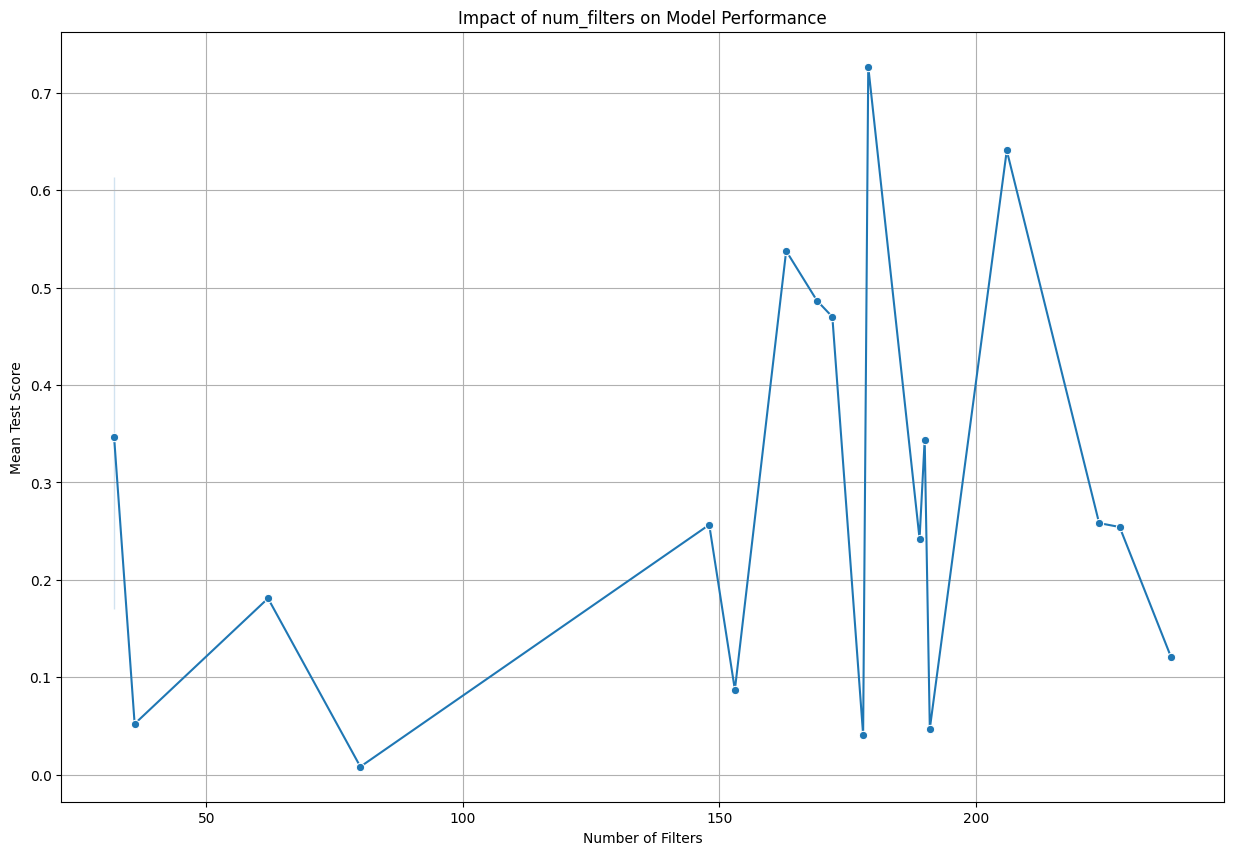

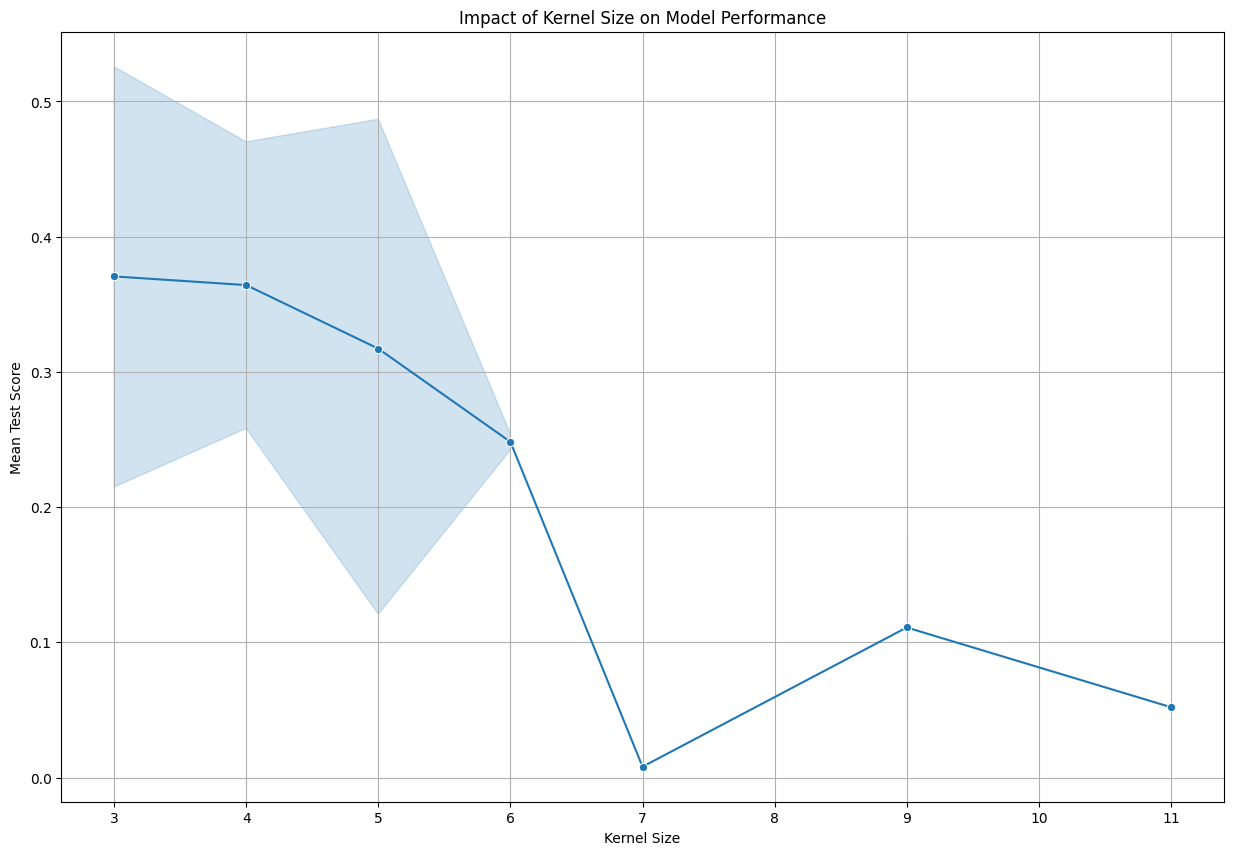

In [41]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 获取搜索结果
results = opt.cv_results_

# 将结果转换为 DataFrame
df = pd.DataFrame(results)

# 打印前几行，查看结构
print(df.head())

# 选择需要查看的参数和指标
param_columns = ['param_num_filters', 'param_kernel_size', 'param_lstm_units', 'param_learning_rate', 'param_epochs']
metric_columns = ['mean_test_score', 'std_test_score', 'rank_test_score']

# 创建一个新的 DataFrame 包含所需信息
df_analysis = df[param_columns + metric_columns]

# 绘图：不同参数对模型准确率的影响
plt.figure(figsize=(15, 10))

# 以参数 `num_filters` 为例，展示它对模型性能的影响
sns.lineplot(x='param_num_filters', y='mean_test_score', data=df_analysis, marker='o')
plt.title('Impact of num_filters on Model Performance')
plt.xlabel('Number of Filters')
plt.ylabel('Mean Test Score')
plt.grid(True)
plt.show()

# 你可以通过修改 x 和 y 参数来绘制其他参数的影响，如 kernel_size, lstm_units, learning_rate 等

# 例如，绘制 kernel_size 对模型准确率的影响
plt.figure(figsize=(15, 10))
sns.lineplot(x='param_kernel_size', y='mean_test_score', data=df_analysis, marker='o')
plt.title('Impact of Kernel Size on Model Performance')
plt.xlabel('Kernel Size')
plt.ylabel('Mean Test Score')
plt.grid(True)
plt.show()


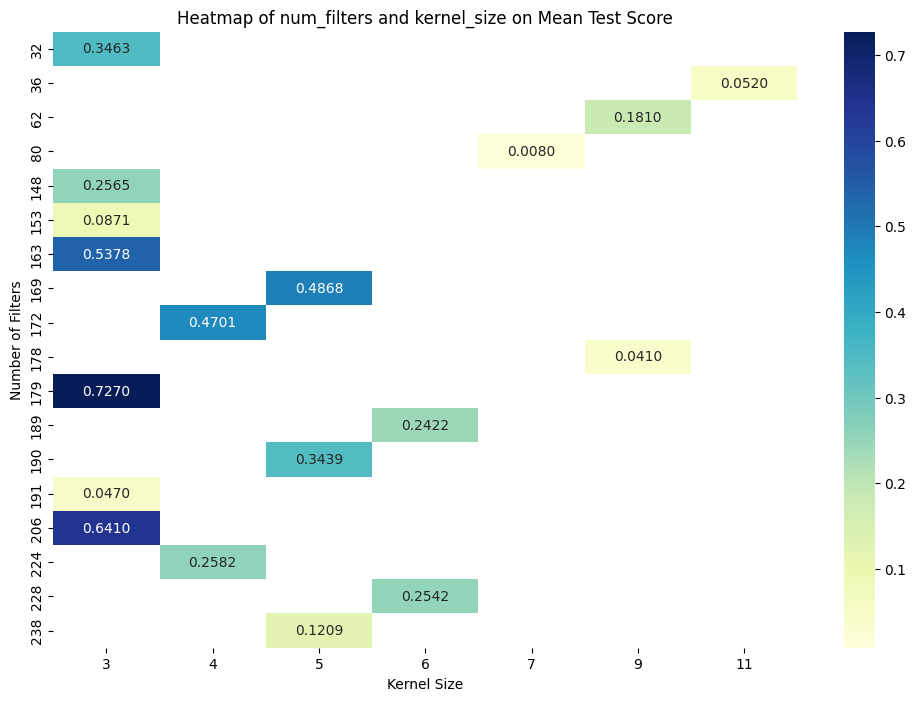

In [44]:
# 去重并取平均值
df_unique = df_analysis.groupby(['param_num_filters', 'param_kernel_size']).mean().reset_index()

# 生成用于热力图的透视表
pivot_table = df_unique.pivot(index='param_num_filters', columns='param_kernel_size', values='mean_test_score')

plt.figure(figsize=(12, 8))
sns.heatmap(pivot_table, annot=True, fmt=".4f", cmap="YlGnBu")
plt.title('Heatmap of num_filters and kernel_size on Mean Test Score')
plt.xlabel('Kernel Size')
plt.ylabel('Number of Filters')
plt.show()


In [ ]:
train_start_time = time.time()
# Train the model
history = model.fit(X_train, y_train_encoded, validation_data=(X_val, y_val_encoded), epochs=5, batch_size=128)
# Record the ending time
train_end_time = time.time()

# Record the starting time for testing
test_start_time = time.time()
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test_encoded, batch_size=32)
# Record the ending time for testing
test_end_time = time.time()

print(f'Test Loss: {loss:.4f}')
print(f'Test Accuracy: {accuracy:.4f}')

# Calculate and print the training time
train_time = train_end_time - train_start_time
print(f"Training time: {train_time:.2f} seconds")

# Calculate and print the testing time
test_time = test_end_time - test_start_time
print(f"Testing time: {test_time:.2f} seconds")

In [ ]:
# Plot the training and validation accuracy over the epochs
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
plt.savefig('acc_plo.jpg')

In [ ]:
# Plot the training and validation loss over the epochs
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
plt.savefig('los_plo.jpg')

In [ ]:
y_pred = model.predict(np.expand_dims(X_test, axis=2))

In [ ]:
attack_types = ['Normal', 'MITM', 'Uploading', 'Ransomware', 'SQL_injection', 'DDoS_HTTP',
                'DDoS_TCP', 'Password', 'Port_Scanning', 'Vulnerability_scanner', 'Backdoor',
                'XSS', 'Fingerprinting', 'DDoS_UDP', 'DDoS_ICMP']
attacks = {attack: idx for idx, attack in enumerate(attack_types)}


In [ ]:
y_pred_classes = np.argmax(y_pred, axis=1)

# Inverse the 'attacks' dictionary to map back numbers to names
inverse_attacks = {v: k for k, v in attacks.items()}

if y_test_encoded.ndim == 2:  # Check if it's a 2D array (one-hot encoded)
    y_test_encoded = np.argmax(y_test_encoded, axis=1)

# Generate the classification report with attack names instead of numbers
class_report = classification_report(y_test_encoded, y_pred_classes, target_names=[inverse_attacks[i] for i in range(len(inverse_attacks))])

print(class_report)

In [ ]:
# Compute the confusion matrix
conf_mat = confusion_matrix(y_test_encoded, y_pred_classes)

# Convert the 'attacks' dictionary to a list of class names ordered by the class number
class_names_ordered = [attack for attack, number in sorted(attacks.items(), key=lambda item: item[1])]

# Plot the heatmap using seaborn
plt.figure(figsize=(15, 10))
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues", xticklabels=class_names_ordered, yticklabels=class_names_ordered)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()
plt.savefig('con_mat.jpg')

In [ ]:
# Compute the confusion matrix
conf_mat = confusion_matrix(y_test_encoded, y_pred_classes)

# Normalize the confusion matrix by dividing each value by the sum of its row (i.e., the number of true instances for each label)
conf_mat_normalized = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]

# Convert the 'attacks' dictionary to a list of class names ordered by the class number
class_names_ordered = [attack for attack, number in sorted(attacks.items(), key=lambda item: item[1])]

# Plot the heatmap using seaborn
plt.figure(figsize=(15, 10))
sns.heatmap(conf_mat_normalized, annot=True, fmt=".2%", cmap="Blues", xticklabels=class_names_ordered, yticklabels=class_names_ordered)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Normalized Confusion Matrix as Percentages')
plt.show()
plt.savefig('con_per.jpg')